# Wire RAG <a href="https://colab.research.google.com/github/appunite/Wire-RAG/blob/main/main_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Install dependencies for colab

In [ ]:
!pip install haystack-ai pinecone-haystack sentence-transformers pinecone transformers
!wget -P utils https://raw.githubusercontent.com/appunite/Wire-RAG/main/utils/url_scraper.py
# !wget -P utils https://raw.githubusercontent.com/appunite/Wire-RAG/main/utils/github_scraper.py

Enter api keys

In [6]:
import os
import getpass
os.environ["PINECONE_API_KEY"] = getpass.getpass("pinecone api key")
os.environ["OPENAI_API_KEY"] = getpass.getpass("open ai api key")
os.environ["GITHUB_API_TOKEN"] = getpass.getpass("github api token (PAT)")

Or load keys from .env file

In [7]:
from dotenv import load_dotenv
import os
load_dotenv()

True

## Populate Pinecone Database

### Scrape URLs


Whitelist: Allow any URL that begins with any element from the white_list.\
Blacklist: Block any URL that begins with any element from the black_list.

In [4]:
import nest_asyncio
from utils.url_scraper import start_scraping

# Apply the nest_asyncio patch to allow nested event loops in Jupyter
nest_asyncio.apply()

starting_url = "https://docs.wire.com"
depth_limit = 2

filter_list = {"white_list": ["https://docs.wire.com"], "black_list": []}
scraped_urls = await start_scraping(starting_url, depth_limit, filter_list)

print(f"Total URLs found: {len(scraped_urls)}")

Total URLs found: 427


### Extract metadata and content

In [5]:
from utils.url_scraper import extract_content_and_metadata, DATE_FORMATS, DATE_PATTERNS

all_documents = []
for u in scraped_urls:
    all_documents += extract_content_and_metadata(u, DATE_FORMATS, DATE_PATTERNS)
print(len(all_documents))

6640


### Scrape Github

In [ ]:
from utils.github_scraper import scrape_md_files

md_documents = await scrape_md_files(org_name="wireapp", api_key=os.getenv("GITHUB_API_TOKEN"), repo_limit=None)
print(len(md_documents))

### Populate database

To delete all records u need to `pip install "pinecone[grpc]"` and run the following code.

In [12]:
# Uncomment to delete all db records
# import os
# from pinecone import Pinecone
# Pinecone(api_key=os.getenv("PINECONE_API_KEY")).Index("default").delete(delete_all=True, namespace='default')

{}

Initialize Pinecone Document Store

In [18]:
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack import Pipeline
from haystack import Document
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore

document_store = PineconeDocumentStore(
    index="default",
    namespace="default",
    dimension=384,
    metric="cosine",
    spec={"serverless": {"region": "us-east-1", "cloud": "aws"}}
)

ready_list = []
for doc in all_documents:
    ready_list.append(Document(content=doc["content"], meta=doc["metadata"]))
for doc in md_documents:
    ready_list.append(Document(content=doc["content"], meta=doc["metadata"]))
print(len(ready_list))

7134


Prepare pipeline components

In [14]:
document_cleaner = DocumentCleaner()
# For all-MiniLM-L6-v2 input text longer than 256 word pieces is truncated.
document_splitter = DocumentSplitter(split_by="word", split_length=256, split_overlap=20)
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)

Create a pipeline to populate the Pinecone Document Store with test case documents

In [15]:
preprocessing_pipeline = Pipeline()

preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

🚅 Components
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

Run the pipeline

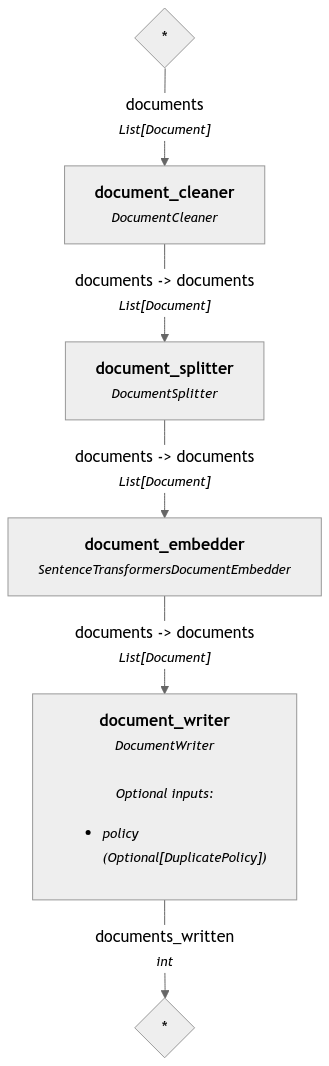

In [17]:
preprocessing_pipeline.run(data = {"document_cleaner": { "documents" : ready_list }})
# preprocessing_pipeline.inputs()
preprocessing_pipeline.show()

## Test RAG with Pinecone Document Store

Restart the kernel and run the following code to test the RAG pipeline with the populated Pinecone Document Store.\
Create pipeline to run a query

In [18]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import Pipeline
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore
from dotenv import load_dotenv

template = """You are a knowledgeable assistant responsible for creating comprehensive documentation based on the following list of documents that refer to the user’s question. The content of these documents may contradict each other, so please prioritize the information from the documents with the most recent dates. If there are contradicting documents with dates labeled as 'None', provide all alternatives and explicitly indicate which parts contradict one another. However, if a document with date labeled as 'None' does not conflict with others, it should be included without special mention.

Instructions:
2. Analyze the Documents:
   - Review each document, noting any conflicting information.
   - Prioritize information from the most recent documents.
3. Handling Documents with 'None' Date:
   - If a document has a date marked as 'None':
     - Include all relevant alternatives and clearly indicate contradictions.
     - If it does not conflict with other documents, include it without special mention.

Output Format:
Your output should be structured using Markdown and include the following sections:
1. Summary:
   - Provide a brief overview of the key findings from all documents.
2. Detailed Analysis:
   - Present detailed descriptions of key points, prioritizing the latest information.
   - Preserve and format any code snippets from the documents appropriately.
   - Present full semantic context retrieved from given documents.
3. Contradictions:
   - For documents dated 'None', list all relevant alternatives and explicitly highlight any contradictions.
   - Do not generate this section if there are no contradictions.

General Guidelines:
- Ensure thoroughness by including all relevant information, aiming for completeness rather than brevity.
- Use headings, lists, and code blocks to enhance readability and organization.
- Given .md files should be the base structure of generated file. If .md files are poor, treat them as regular source.

User Question: {{question}}
Documents to Analyze:
{% for doc in documents %}
Date: {{doc.meta['date']}}
Title: {{doc.meta['title']}} - {{doc.meta['headline']}}
Content: 
{{doc.content}}
{% endfor %}"""

load_dotenv()

document_store = PineconeDocumentStore(
    index="default",
    namespace="default",
    dimension=384,
    metric="cosine",
    spec={"serverless": {"region": "us-east-1", "cloud": "aws"}}
)

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = PineconeEmbeddingRetriever(document_store=document_store, top_k=30)
prompt_builder = PromptBuilder(template=template)
generator = OpenAIGenerator(model="gpt-4o-mini") # "gpt-4o-mini" "gpt-4o" "gpt-3.5-turbo"
answer_builder = AnswerBuilder()

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("generator", generator)
rag_pipeline.add_component("answer_builder", answer_builder)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("retriever", "answer_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")
rag_pipeline.connect("generator.replies", "answer_builder.replies")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: PineconeEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> answer_builder.replies (List[str])

Run the pipeline with a query

In [19]:
query = "Federation, how to make requests between two federated backends."
result = rag_pipeline.run({
    "text_embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

print(result['answer_builder']['answers'][0].query)
print(result['answer_builder']['answers'][0].data)
for i, doc in enumerate(result['answer_builder']['answers'][0].documents):
    print(f"{i + 1}. {doc.meta['headline']} - {doc.to_dict()['url']}")

with open("./output.md", "w") as f:
    f.write(result['answer_builder']['answers'][0].data)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Federation, how to make requests between two federated backends.
# Summary

The documentation collectively outlines the framework and requirements for making requests between two federated backends using the Wire 0.0.4 API. Key points emphasize the roles of the *Federator* and *Federation Ingress* components in facilitating communication between backends, including authentication and authorization processes. The most recent updates highlight enhancements in processing federated requests, the ability to send requests to multiple backends in parallel, and the evolution of API conventions to improve functionality.

# Detailed Analysis

## Federated Requests Overview
- According to the **2023-01-10** document, every federated API request involves a service component (like brig or galley) in one backend, which communicates through the *Federator*. The response is relayed back via the *Federator Ingress* in the other backend.
  
## Backend to Backend Communication
- The document marked **Non